# Supervised Anomaly Detection Using MLP

Using the dataset https://www.kaggle.com/datasets/what0919/intrusion-detection/code, the objective is to build a network intrusion detection system to detect the class of attacks (multinomial classification) in the Network. Here's the description of each feature:

Column| Description| Feature Type
------------|--------------------|----------------------
Duration | Length of time duration of the connection | Numerical
Protocol_type | Protocol used in the connection | Categorical
Service | Destination network service used | Categorical
Flag | Status of the connection | Categorical
Src_bytes | Number of data bytes transferred from source to destination  | Numerical
Dst_bytes | Number of data bytes transferred from destination to source | Numerical
Land | (1: source, destination IP addresses and port numbers are equal, 0: o/w) | Categorical
Wrong_fragment | Total number of wrong fragments in this connection | Numerical
Urgent | Number of urgent packets with urgent bits | Numerical
Hot | Number of 'hot' indicators in the content such as: entering a system directory, creating programs and executing programs | Numerical
Num_failed _logins | Count of failed login attempts | Numerical
Login Status | (1: success, 0: failed) | Categorical
Num_compromised | Number of 'compromised' conditions | Numerical
Root_shell | (1: root shell is obtained, 0: o/w) | Categorical
Su_attempted | (1: su root command is attempted, 0: o/w) | Categorical
Num_root | Number of 'root' accesses or number of operations performed as a root in the connection | Numerical
Num_file_creations | Number of file creation operations in the connection | Numerical
Num_shells | Number of shell prompts | Numerical
Num_access_files | Number of operations on access control files | Numerical
Is_guest_login | (1 : login is a 'guest' login, 0: o/w) | Categorical
Count | Number of connections to the same destination host as the current connection in the past two seconds | Numerical
Srv_count | Number of connections to the same service (port number) as the current connection in the past two seconds | Numerical
Serror_rate | The percentage of connections that have activated the **flag** s0, s1, s2 or s3, among the connections aggregated in **count** | Numerical
Srv_serror_rate | The percentage of connections that have activated the **flag** s0, s1, s2 or s3, among the connections aggregated in **srv_count** | Numerical
Rerror_rate | The percentage of connections that have activated the **flag** REJ, among the connections aggregated in **count** | Numerical
Srv_rerror_rate | The percentage of connections that have activated the **flag** REJ, among the connections aggregated in **srv_count** | Numerical
Same_srv_rate | The percentage of connections that were to the same service, among the connections aggregated in **count** | Numerical
Diff_srv_rate | The percentage of connections that were to different services, among the connections aggregated in **count** | Numerical
Srv_diff_host_rate | The percentage of connections that were to different destination machines among the connections aggregated in **srv_count** | Numerical
Dst_host_count | Number of connections having the same destination host IP address | Numerical
Dst_host_srv_count | Number of connections having the same port number | Numerical
Dst_host_same _srv_rate | The percentage of connections that were to the same service, among the connections aggregated in **dst_host_count** | Numerical
Dst_host_diff_srv_rate | The percentage of connections that were to different services, among the connections aggregated in **dst_host_count** | Numerical
Dst_host_same _src_port_rate | The percentage of connections that were to the same source port, among the connections aggregated in **dst_host_srv_count** | Numerical
Dst_host_srv_diff_host_rate | The percentage of connections that were to different destination machines, among the connections aggregated in **dst_host_srv_count** | Numerical
Dst_host_serror_rate | The percentage of connections that have activated the **flag** s0, s1, s2 or s3, among the connections aggregated in **dst_host_count** | Numerical
Dst_host_srv_s error_rate | The percent of connections that have activated the **flag** s0, s1, s2 or s3, among the connections aggregated in **dst_host_srv_count** | Numerical
Dst_host_rerror_rate | The percentage of connections that have activated the **flag** REJ, among the connections aggregated in **dst_host_count** | Numerical
Dst_host_srv_rerror_rate | The percentage of connections that have activated the **flag** REJ, among the connections aggregated in **dst_host_srv_count** | Numerical
Attack | (normal or DOS or PROBE or R2L or U2R) | Target


## Setup

In [129]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import pandas as pd
import numpy as np
import keras
from keras.utils import FeatureSpace
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard

## Preparing the data

In [132]:
data_path = './data.csv'
dataframe = pd.read_csv(data_path)
print(dataframe.shape)

(125973, 41)


Here is a preview of a few samples:

In [135]:
dataframe.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,xAttack
0,0,icmp,20,2,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,45,2,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,icmp,50,4,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,dos
3,0,icmp,25,2,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,icmp,25,2,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


Handle imbalanced Data:

xAttack
normal    67343
dos       45927
probe     11656
r2l         995
u2r          52
Name: count, dtype: int64


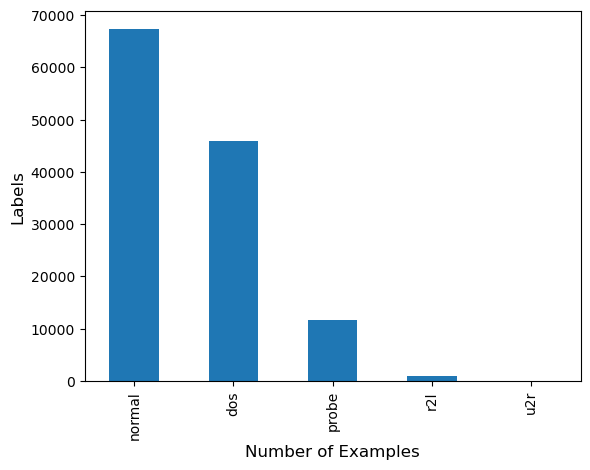

In [138]:
# plot out the balance of data
print(dataframe['xAttack'].value_counts())

ax = dataframe['xAttack'].value_counts().plot.bar()
ax.set_xlabel("Number of Examples", fontsize=12)
ax.set_ylabel("Labels", fontsize=12)
plt.show()

In [140]:
# separate actual counts
normal = dataframe['xAttack'].value_counts()['normal']
dos = dataframe['xAttack'].value_counts()['dos']
probe = dataframe['xAttack'].value_counts()['probe']
r2l = dataframe['xAttack'].value_counts()['r2l']
u2r = dataframe['xAttack'].value_counts()['u2r']
normal, dos, probe, r2l, u2r

(67343, 45927, 11656, 995, 52)

In [142]:
# handling the class imbalance
total = normal + dos + probe + r2l + u2r
weight_for_0 = (1 / normal) * (total) / 5.0
weight_for_1 = (1 / dos) * (total) / 5.0
weight_for_2 = (1 / probe) * (total) / 5.0
weight_for_3 = (1 / r2l) * (total) / 5.0
weight_for_4 = (1 / u2r) * (total) / 5.0

class_weight = {0: weight_for_0, 1: weight_for_1,
                2: weight_for_2, 3: weight_for_3,
                4: weight_for_4} #create a dictionary

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))
print("Weight for class 2: {:.2f}".format(weight_for_2))
print("Weight for class 3: {:.2f}".format(weight_for_3))

Weight for class 0: 0.37
Weight for class 1: 0.55
Weight for class 2: 2.16
Weight for class 3: 25.32


In [144]:
dataframe['xAttack'] = dataframe['xAttack'].map({'normal':0,'dos':1,'probe':2,'r2l':3,'u2r':4})

Train, Validation, Test Split

In [147]:
train_dataframe = dataframe.sample(frac=0.8, random_state=42)
dataframe = dataframe.drop(train_dataframe.index)
test_dataframe = dataframe.sample(frac=0.5, random_state=42)
val_dataframe = dataframe.drop(test_dataframe.index)
print(train_dataframe.shape)
print(val_dataframe.shape)
print(test_dataframe.shape)

(100778, 41)
(12597, 41)
(12598, 41)


Generate tf.data.Dataset objects for each dataframe:

In [150]:
def dataframe_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop("xAttack") # target label
    encoded_labels = to_categorical(LabelEncoder().fit_transform(labels), num_classes=5)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), encoded_labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

batch_size = 32
train_ds = dataframe_to_dataset(train_dataframe, batch_size=batch_size)
val_ds = dataframe_to_dataset(val_dataframe, batch_size=batch_size)
test_ds = dataframe_to_dataset(test_dataframe, shuffle=False, batch_size=batch_size)

In [152]:
for feature_batch, label_batch in train_ds.take(1):
  print('labels:', label_batch )

labels: tf.Tensor(
[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]], shape=(32, 5), dtype=float64)


## Configuring a FeatureSpace

In [155]:
feature_space = FeatureSpace(
    features={
        # Categorical features encoded as integers
        "flag": "integer_categorical",
        "land": "integer_categorical",
        "logged_in": "integer_categorical",
        "root_shell": "integer_categorical",
        "su_attempted": "integer_categorical",
        "is_host_login": "integer_categorical",
        "is_guest_login": "integer_categorical",
        # Categorical feature encoded as string
        "protocol_type": "string_categorical",
        # Numerical features to normalize
        "duration": "float_normalized",
        "service": "float_normalized",
        "src_bytes": "float_normalized",
        "dst_bytes": "float_normalized",
        "wrong_fragment": "float_normalized",
        "urgent": "float_normalized",
        "hot": "float_normalized",
        "num_failed_logins": "float_normalized",
        "num_compromised": "float_normalized",
        "num_root": "float_normalized",
        "num_file_creations": "float_normalized",
        "num_shells": "float_normalized",
        "num_access_files": "float_normalized",
        "count": "float_normalized",
        "srv_count": "float_normalized",
        "dst_host_count": "float_normalized",
        "dst_host_srv_count": "float_normalized",
        "serror_rate": "float_normalized",
        "srv_serror_rate": "float_normalized",
        "rerror_rate": "float_normalized",
        "srv_rerror_rate": "float_normalized",
        "same_srv_rate": "float_normalized",
        "diff_srv_rate": "float_normalized",
        "srv_diff_host_rate": "float_normalized",
        "dst_host_same_srv_rate": "float_normalized",
        "dst_host_diff_srv_rate": "float_normalized",
        "dst_host_same_src_port_rate": "float_normalized",
        "dst_host_srv_diff_host_rate": "float_normalized",
        "dst_host_serror_rate": "float_normalized",
        "dst_host_srv_serror_rate": "float_normalized",
        "dst_host_rerror_rate": "float_normalized",
        "dst_host_srv_rerror_rate": "float_normalized",
    },
    # Our utility will one-hot encode all categorical
    # features and concat all features into a single
    # vector (one vector per sample).
    output_mode="concat",
)

In [157]:
train_ds_with_no_labels = train_ds.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)

In [159]:
for x, _ in train_ds.take(1):
    preprocessed_x = feature_space(x)
    print("preprocessed_x.shape:", preprocessed_x.shape)
    print("preprocessed_x.dtype:", preprocessed_x.dtype)

preprocessed_x.shape: (32, 66)
preprocessed_x.dtype: <dtype: 'float32'>


In [161]:
preprocessed_train_ds = train_ds.map(
    lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
preprocessed_train_ds = preprocessed_train_ds.prefetch(tf.data.AUTOTUNE)

preprocessed_val_ds = val_ds.map(
    lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
preprocessed_val_ds = preprocessed_val_ds.prefetch(tf.data.AUTOTUNE)

preprocessed_test_ds = test_ds.map(
    lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
preprocessed_test_ds = preprocessed_val_ds.prefetch(tf.data.AUTOTUNE)

In [163]:
preprocessed_train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 66), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Build a training model

- A training model that expects preprocessed features (one sample = one vector)
- An inference model that expects raw features (one sample = dict of raw feature values)

In [167]:
dict_inputs = feature_space.get_inputs()
encoded_features = feature_space.get_encoded_features()

x = keras.layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation="relu")(encoded_features)
x = keras.layers.Dropout(0.7)(x)
x = keras.layers.Dense(32, kernel_regularizer=regularizers.l2(0.001), activation="relu")(x)
x = keras.layers.Dropout(0.6)(x)
x = keras.layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation="relu")(x)
predictions = keras.layers.Dense(5, activation="softmax")(x) # 5 classes 

training_model = keras.Model(inputs=encoded_features, outputs=predictions)
training_model.compile(
    optimizer=keras.optimizers.Adam(0.001), loss="categorical_crossentropy", metrics=["accuracy"]
)

inference_model = keras.Model(inputs=dict_inputs, outputs=predictions)

#### Callbacks

In [170]:
checkpoint = ModelCheckpoint('./checkpoints/best_model.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

In [172]:
reduce_LR = ReduceLROnPlateau(monitor='val_loss',factor = 0.5, patience=2,cooldown=0, min_lr = 0.00001)

In [174]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='./logs',
    histogram_freq=0, # freq in epochs
    write_graph=True,
    write_images=True, # whether to write model weights to see
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None
)

In [176]:
#TB = TensorBoard(log_dir=log_dir, 
#                    histogram_freq=1, # freq in epochs
#                    write_graph=True, # T/F for seeing the graph in TB
#                    #write_grads=True, # writing the gradients
#                    batch_size=batch_size, # size of batches for histogram
#                    write_images=True # whether to write model weights to see
#                )

## Train the model

In [179]:
history = training_model.fit(
    preprocessed_train_ds,
    epochs=20,
    validation_data=preprocessed_val_ds,
    verbose=2,
    class_weight = class_weight,
    callbacks=[checkpoint,reduce_LR, tensorboard_callback])

Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.91300, saving model to ./checkpoints/best_model.keras
3150/3150 - 6s - 2ms/step - accuracy: 0.7147 - loss: 1.3360 - val_accuracy: 0.9130 - val_loss: 0.6761 - learning_rate: 0.0010
Epoch 2/20

Epoch 2: val_accuracy did not improve from 0.91300
3150/3150 - 5s - 1ms/step - accuracy: 0.7947 - loss: 1.1629 - val_accuracy: 0.8787 - val_loss: 0.7518 - learning_rate: 0.0010
Epoch 3/20

Epoch 3: val_accuracy improved from 0.91300 to 0.92474, saving model to ./checkpoints/best_model.keras
3150/3150 - 5s - 1ms/step - accuracy: 0.8124 - loss: 0.8824 - val_accuracy: 0.9247 - val_loss: 0.5655 - learning_rate: 0.0010
Epoch 4/20

Epoch 4: val_accuracy did not improve from 0.92474
3150/3150 - 4s - 1ms/step - accuracy: 0.8229 - loss: 0.8929 - val_accuracy: 0.8936 - val_loss: 0.8803 - learning_rate: 0.0010
Epoch 5/20

Epoch 5: val_accuracy improved from 0.92474 to 0.92546, saving model to ./checkpoints/best_model.keras
3150/3150 - 4s - 1ms/step - 

In [181]:
def plot_train(hist):
    h = hist.history
    if 'accuracy' in h:
        meas='accuracy'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

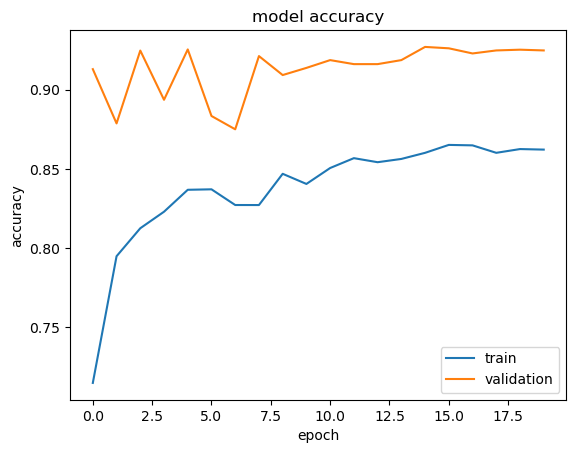

In [183]:
plot_train(history)

## Evalute the model

In [185]:
loss, accuracy = training_model.evaluate(preprocessed_test_ds)
print("Accuracy", accuracy)

394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - accuracy: 0.9293 - loss: 0.6021
Accuracy 0.9248233437538147


## Loading the Best Model

In [188]:
from tensorflow.keras.models import load_model
# Load the entire model
best_training_model = load_model('./checkpoints/best_model.keras')

## Inference with the loaded model

In [250]:
sample={
    "flag": 4,
    "land": 0,
    "logged_in": 0,
    "root_shell": 0,
    "su_attempted": 0,
    "is_host_login": 0,
    "is_guest_login": 0,
    "protocol_type": "icmp",
    "duration": 0,
    "service": 25,
    "src_bytes": 0,
    "dst_bytes": 0,
    "wrong_fragment": 0,
    "urgent": 0,
    "hot": 0,
    "num_failed_logins": 0,
    "num_compromised": 0,
    "num_root": 0,
    "num_file_creations": 0,
    "num_shells": 0,
    "num_access_files": 0,
    "count": 110,
    "srv_count": 110,
    "dst_host_count": 255,
    "dst_host_srv_count": 255,
    "serror_rate": 1,
    "srv_serror_rate": 1,
    "rerror_rate": 0,
    "srv_rerror_rate": 0,
    "same_srv_rate": 1,
    "diff_srv_rate": 0,
    "srv_diff_host_rate": 0,
    "dst_host_same_srv_rate": 1,
    "dst_host_diff_srv_rate": 0,
    "dst_host_same_src_port_rate": 0,
    "dst_host_srv_diff_host_rate": 0,
    "dst_host_serror_rate": 0.65,
    "dst_host_srv_serror_rate": 0.65,
    "dst_host_rerror_rate": 0.32,
    "dst_host_srv_rerror_rate": 0.32,
}

In [252]:
encoded_sample = feature_space(dict(sample))
encoded_sample = tf.expand_dims(encoded_sample, axis=0) 

In [254]:
print("preprocessed_x.shape:", encoded_sample.shape)

preprocessed_x.shape: (1, 66)


In [256]:
predictions = best_training_model.predict(encoded_sample)
predicted_class_indices = np.argmax(predictions, axis=1)
class_mapping = {0: 'normal', 1: 'dos', 2: 'probe', 3: 'r2l', 4: 'u2r'}
predicted_classes = [class_mapping[i] for i in predicted_class_indices]
print(predicted_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
['dos']


In [258]:
#if using inference model
#input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
#predictions = inference_model.predict(input_dict)
#predicted_class_indices = np.argmax(predictions, axis=1)
#class_mapping = {0: 'normal', 1: 'dos', 2: 'probe', 3: 'r2l', 4: 'u2r'}
#predicted_classes = [class_mapping[i] for i in predicted_class_indices]
#print(predicted_classes)

In [ ]:
#view tensorboard
#open anaconda prompt
#cd to folder containing log folder
#tensorboard --logdir=logs/fit